## SVD

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [23]:
def data_loader_main(data):
    data = pd.read_table(data, sep = '\t', header=None)
    data.columns = ["userid", "itemid", "rating", "timestamp"]
    
    num_users = data['userid'].unique().shape[0]
    num_movies = data['itemid'].unique().shape[0]
    
    rating = np.zeros((num_users, num_movies))
    
    for row in data.itertuples():
        rating[row[1]-1, row[2]-1] = row[3]
    
    return rating, num_users, num_movies

# To get overall matrix in validation set, we get num_users, num_movies as inputs
def data_loader_val(data, num_users, num_movies):
    data = pd.read_table(data, sep = '\t', header=None)
    data.columns = ["userid", "itemid", "rating", "timestamp"]
    
    rating = np.zeros((num_users, num_movies))
    
    for row in data.itertuples():
        rating[row[1]-1, row[2]-1] = row[3]
    
    return rating

In [24]:
ratings, num_users, num_movies = data_loader_main('./ml-100k/u.data')
train = data_loader_val('./ml-100k/u1.base', num_users, num_movies)
test = data_loader_val('./ml-100k/u1.test', num_users, num_movies)

In [25]:
class SVD():
            
    def __init__(self, train, test, learning_rate = 0.01, n_factors = 15, epoch = 10, 
                 reg = 0.01, seed = 1234, verbose = True):
        
        self.train = train
        self.test = test
        self.learning_rate = learning_rate
        self.n_factors = n_factors
        self.n_iters = epoch
        self.reg = reg
        self.seed = seed
        self.verbose = verbose
    
    def fit(self):
        """
        update matrix with latent factors
        """

        n_users, n_items = self.train.shape

        #initialize parameters
        self.user_factors = np.random.normal(scale = 1.0/self.n_factors, size=(n_users, self.n_factors))
        self.item_factors = np.random.normal(scale = 1.0/self.n_factors, size=(n_items, self.n_factors))
        
        #initialize biases
        self.b_u = np.zeros(n_users)
        self.b_i = np.zeros(n_items)
        self.b = np.mean(ratings[np.where(self.train != 0)])
        
        #train with epochs
        self.train_process = []
        
        start = timer()
        
        for epoch in range(self.n_iters):
            start_epoch = timer()
            
            for u in range(n_users):
                for i in range(n_items):
                    if self.train[u, i] > 0:
                        self.gradient_descent(u, i, self.train[u,i])
            
            rmse = self.rmse()
            self.train_process.append(rmse)
            
            if self.verbose == True:
                print("Epoch : %d, rmse = %.4f, time = %.4f" % (epoch+1, rmse, timer()-start_epoch))
                
        print()
        print("Time Spent on overall fitting: %.4f sec" % (timer() - start))

        return self
    
    def rmse(self):
        """
        return rmse
        """
        
        x_test, y_test = self.test.nonzero()
        predicted = self.prediction_matrix()
        mse = 0
        
        for x, y in zip(x_test, y_test):
            mse += pow(self.test[x, y] - predicted[x, y], 2)
        
        return np.sqrt(mse/len(x_test))
        
    def gradient(self, error, u, i):
        """
        gradient of latent feature
        
        error: rating - prediction error
        u: user index
        i: item index
        """
        
        dp = (error * self.item_factors[i,:]) - (self.reg * self.user_factors[u,:])
        dq = (error * self.user_factors[u,:]) - (self.reg * self.item_factors[i,:])
        
        return dp, dq
              
    def gradient_descent(self, u, i, rating):
        """
        applying gradient descent
        
        u: user index
        i: item index
        rating: rating of (u,i)
        """
        
        predict = self.prediction(u,i)
        error = rating - predict
        
        self.b_u[u] = self.learning_rate * (error - self.reg * self.b_u[u]) 
        self.b_i[i] = self.learning_rate * (error - self.reg * self.b_i[i])

        dp, dq = self.gradient(error, u, i)
        self.user_factors[u,:] += self.learning_rate * dp
        self.item_factors[i,:] += self.learning_rate * dq
 
    def prediction_matrix(self):
        """
        get full prediction matrix
        """
              
        return self.b + self.b_u[:, np.newaxis] + self.b_i[np.newaxis,:] + self.user_factors.dot(self.item_factors.T)
    
    def prediction(self, u, i):
        """
        get predicted rating by user i on item j
        """
        
        return self.b + self.b_u[u] + self.b_i[i] + self.user_factors[u, :].dot(self.item_factors[i,:].T)

In [26]:
svd_params = {'learning_rate': 0.01, 'n_factors': 40, 'epoch': 10, 'reg': 0.01}

svd = SVD(train, test, **svd_params)
svd.fit()

Epoch : 1, rmse = 1.1496, time = 2.0790
Epoch : 2, rmse = 1.1496, time = 2.3106
Epoch : 3, rmse = 1.1493, time = 2.3178
Epoch : 4, rmse = 1.1481, time = 2.3029
Epoch : 5, rmse = 1.1439, time = 2.3080
Epoch : 6, rmse = 1.1313, time = 2.2986
Epoch : 7, rmse = 1.1056, time = 2.3141
Epoch : 8, rmse = 1.0742, time = 2.3096
Epoch : 9, rmse = 1.0455, time = 2.2935
Epoch : 10, rmse = 1.0218, time = 2.2975

Time Spent on overall fitting: 22.8339 sec


Text(0, 0.5, 'RMSE')

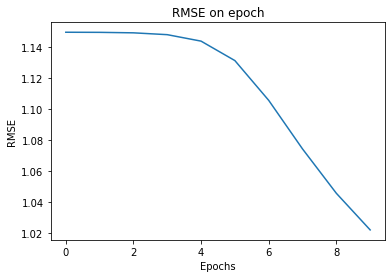

In [27]:
plt.plot(svd.train_process)
plt.title('RMSE on epoch')
plt.xlabel('Epochs')
plt.ylabel('RMSE')

## 5 fold Cross Validation 

In [28]:
train_set = ['./ml-100k/u1.base','./ml-100k/u2.base','./ml-100k/u3.base','./ml-100k/u4.base','./ml-100k/u5.base']
test_set = ['./ml-100k/u1.test','./ml-100k/u2.test','./ml-100k/u3.test','./ml-100k/u4.test','./ml-100k/u5.test']

---------------- Set 1 ----------------
Epoch : 1, rmse = 1.1497, time = 2.2136
Epoch : 2, rmse = 1.1496, time = 2.3064
Epoch : 3, rmse = 1.1494, time = 2.3148
Epoch : 4, rmse = 1.1483, time = 2.3272
Epoch : 5, rmse = 1.1445, time = 2.3098
Epoch : 6, rmse = 1.1328, time = 2.2986
Epoch : 7, rmse = 1.1076, time = 2.3272
Epoch : 8, rmse = 1.0753, time = 2.3049
Epoch : 9, rmse = 1.0458, time = 2.3078
Epoch : 10, rmse = 1.0225, time = 2.3078

Time Spent on overall fitting: 23.0206 sec

---------------- Set 2 ----------------
Epoch : 1, rmse = 1.1268, time = 2.2072
Epoch : 2, rmse = 1.1267, time = 2.4798
Epoch : 3, rmse = 1.1262, time = 2.5040
Epoch : 4, rmse = 1.1244, time = 2.5177
Epoch : 5, rmse = 1.1183, time = 2.5060
Epoch : 6, rmse = 1.1010, time = 2.5232
Epoch : 7, rmse = 1.0708, time = 2.5079
Epoch : 8, rmse = 1.0397, time = 2.5316
Epoch : 9, rmse = 1.0130, time = 2.3781
Epoch : 10, rmse = 0.9916, time = 2.3696

Time Spent on overall fitting: 24.5272 sec

---------------- Set 3 -----

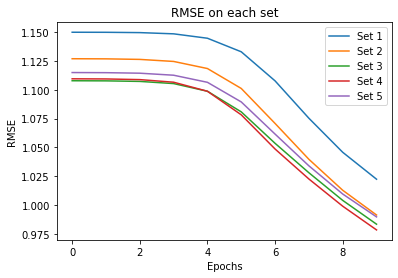


-------------
Overall RMSE: 0.989927821467329


In [29]:
for i in range(len(train_set)):
    ratings, num_users, num_movies = data_loader_main('./ml-100k/u.data')
    train = data_loader_val(train_set[i], num_users, num_movies)
    test = data_loader_val(test_set[i], num_users, num_movies)
    
    svd_params = {'learning_rate': 0.01, 'n_factors': 40, 'epoch': 10, 'reg': 0.01}
    svd = SVD(train, test, **svd_params)
    
    print('----------------','Set', i+1, '----------------')
    svd.fit()
    print()
    
    #plotting each set's rmse
    plt.plot(svd.train_process, label = 'Set %i' % (i+1))
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    
    final_rmse = []
    final_rmse.append(svd.train_process[-1])
    
plt.legend()
plt.title('RMSE on each set')
plt.show()    

print()
print("-------------")
print("Overall RMSE:", np.mean(final_rmse))